In [167]:
import cv2
import matplotlib.pyplot as plt
import scipy.spatial.distance as ssd
import numpy as np
import os
from os import listdir

### Test HOG

In [25]:
#reading image
img1 = cv2.imread('airplane_query.jpg')  
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)


Gx_img1 = cv2.Sobel(img1,cv2.CV_64F,1,0,ksize=3)
Gy_img1 = cv2.Sobel(img1,cv2.CV_64F,0,1,ksize=3)

'''
Gx_img1 = np.absolute(Gx_img1) * 255/np.max(Gx_img1)
plt.imshow(Gx_img1,cmap = plt.get_cmap('binary'))
plt.show()

Gy_img1 = np.absolute(Gy_img1) * 255/np.max(Gy_img1)
plt.imshow(Gy_img1,cmap = plt.get_cmap('binary'))
plt.show()
'''

"\nGx_img1 = np.absolute(Gx_img1) * 255/np.max(Gx_img1)\nplt.imshow(Gx_img1,cmap = plt.get_cmap('binary'))\nplt.show()\n\nGy_img1 = np.absolute(Gy_img1) * 255/np.max(Gy_img1)\nplt.imshow(Gy_img1,cmap = plt.get_cmap('binary'))\nplt.show()\n"

In [26]:
ForceGradient_img1 = np.sqrt(np.power(Gx_img1,2)+np.power(Gy_img1,2))

In [37]:
ForceGradient_img1.shape

(178, 393, 3)

In [36]:
aretes.shape

(178, 393, 3)

In [40]:
aretes = ForceGradient_img1>80
plt.imshow(aretes, plt.get_cmap('binary'))
plt.show()

ValueError: Unsupported dtype

<Figure size 432x288 with 1 Axes>

In [41]:
FG_img1, AG_img1 = cv2.cartToPolar(Gx_img1, Gy_img1, angleInDegrees=True)

In [51]:
np.max(FG_img1)

930.6266705827853

### Test SIFT

33


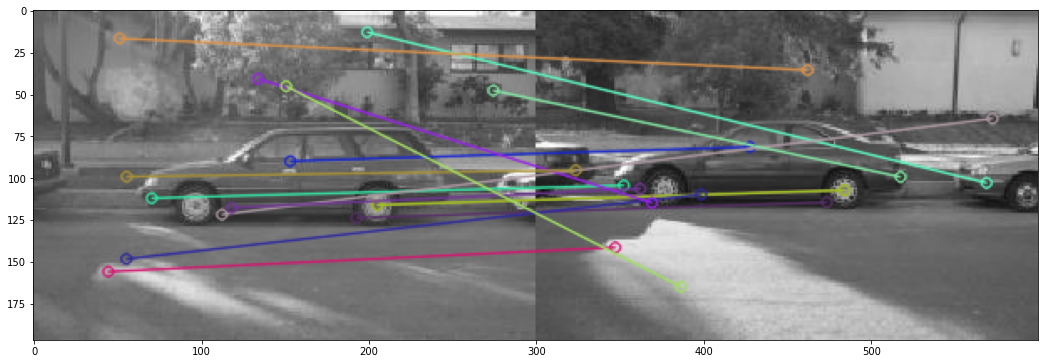

In [369]:
# voir: https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html
#reading image
img1 = cv2.imread('car_query.jpg',cv2.IMREAD_GRAYSCALE)  
img2 = cv2.imread('database/car_2.jpg',cv2.IMREAD_GRAYSCALE)
#keypoints
sift = cv2.SIFT_create(nOctaveLayers = 2, contrastThreshold=0.02,edgeThreshold =5,sigma=4)
keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

#find matches with brute force matching:
bf = cv2.BFMatcher_create(cv2.NORM_L2,crossCheck=True) #NORM_L2 prend la distance euclidienne
matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)
print(len(matches))
plt.figure(figsize = (18,10))
imageout3 = cv2.drawMatches(img1,keypoints_1,img2,keypoints_2,matches[0:15], None, flags = 2)
plt.imshow(imageout3)
plt.show()


## SIFT search in database

In [372]:
def correspond_SIFT(descriptors_1,descriptors_2,keypoints_1,keypoints_2):
    bf = cv2.BFMatcher_create(cv2.NORM_L2) #NORM_L2 prend la distance euclidienne
    matches = bf.knnMatch(descriptors_1,descriptors_2,k=2)
    bonMatch = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            bonMatch.append([m])
    number_keypoints = 0
    if len(keypoints_1) <= len(keypoints_2):
        number_keypoints = len(keypoints_1)
    else:
        number_keypoints = len(keypoints_2)
    indice = len(bonMatch)/number_keypoints * 100
    return indice


def search_database(query):
    im_query = cv2.imread(query,cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create(nOctaveLayers = 2, contrastThreshold=0.02,edgeThreshold =5,sigma=4)
    result = {}
    for images in os.listdir("./database/"):
        database = cv2.imread("./database/"+images,cv2.COLOR_BGR2GRAY)
        keypoints_1, descriptors_1 = sift.detectAndCompute(im_query,None)
        keypoints_2, descriptors_2 = sift.detectAndCompute(database,None)
        #find matches with brute force matching:
        score = correspond_SIFT(descriptors_1,descriptors_2,keypoints_1,keypoints_2)
        result[score] = images
    myKeys = list(result.keys())
    myKeys.sort()
    sorted_dict = {i: result[i] for i in myKeys}
    print(sorted_dict)


In [373]:
search_database("lotus_query.jpg")

{0.0: 'pickles_4.jpg', 1.5873015873015872: 'lotus_5.jpg', 3.1746031746031744: 'pickles_5.jpg', 3.389830508474576: 'lotus_3.jpg', 3.7037037037037033: 'dolphin_2.jpg', 4.761904761904762: 'lotus_2.jpg', 6.349206349206349: 'lotus_1.jpg', 11.76470588235294: 'airplane_4.jpg'}


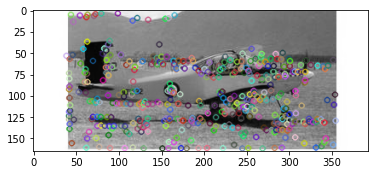

In [351]:
#reading image
img2 = cv2.imread('./database/airplane_1.jpg')  
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#keypoints
sift = cv2.xfeatures2d.SIFT_create(	nOctaveLayers = 3, contrastThreshold=0.04,edgeThreshold = 10,sigma=1.6)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

img_2 = cv2.drawKeypoints(gray2,keypoints_2,img2)
plt.imshow(img_2)
plt.show()


In [21]:
descriptors_1.shape

(295, 128)

In [20]:
descriptors_2.shape

(447, 128)

### Fonction correspondance d'image pour SIFT

In [248]:
def correspond(descriptors_1,descriptors_2,keypoints_1,keypoints_2):
    bf = cv2.BFMatcher_create(cv2.NORM_L2) #NORM_L2 prend la distance euclidienne
    matches = bf.knnMatch(descriptors_1,descriptors_2,k=2)
    bonMatch = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            bonMatch.append([m])
    number_keypoints = 0
    if len(keypoints_1) <= len(keypoints_2):
        number_keypoints = len(keypoints_1)
    else:
        number_keypoints = len(keypoints_2)
    print("matches:")
    print(len(matches))
    print("number_keypoint")
    print([len(keypoints_1), len(keypoints_2), number_keypoints])

    print("bon_point")
    print(len(bonMatch))
    indice = len(bonMatch)/number_keypoints * 100
    return indice